In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow.keras
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2
from keras.layers import Activation
from keras import activations
from keras.layers import Add
from keras.layers import AveragePooling2D

###use this only for model tweaking , it is designed to be easy for rough identification of hyperparameters..

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/fer2013.csv')

In [4]:
print(data.head)
print(data["Usage"].value_counts())

<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 colum

In [5]:
lst2=[]
for i in range(data.shape[0]):
  lst=[]
  for j in (data["pixels"][i]).split():
    lst.append(int(j))
  lst2.append(lst)
final=np.array(lst2)
print(final.shape)

(35887, 2304)


In [6]:
x_data=final.reshape((35887,48,48,1))
y_data=np.array(data["emotion"])


     

In [7]:
x_train=[]
y_train=[]
x_val = []
y_val = []
x_test=[]
y_test=[]
for i in range(x_data.shape[0]):
  if data["Usage"][i]=="Training":
    x_train.append(x_data[i])
    y_train.append(y_data[i])
  elif data["Usage"][i] == "PublicTest":
    x_val.append(x_data[i])
    y_val.append(y_data[i])
  else:
    x_test.append(x_data[i])
    y_test.append(y_data[i])
x_train=np.array(x_train)
y_train=np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)
x_test=np.array(x_test)
y_test=np.array(y_test)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(28709, 48, 48, 1) (28709,) (3589, 48, 48, 1) (3589,)


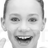

[0 1 2 3 4 5 6]


In [8]:
cv2_imshow(x_test[10])
print(np.unique(y_train))

##parameters of training
syntax:depth,activation,keranl_intialisation,bias initialisation

In [31]:
my_learning_rate=0.0005  #0.0008
iters=50  #100
batch_len=32  #64

##CONVOLUTION AND POOLING 
# syntax: in that array add c for convulution2d and p for maxpool,activation, kernal initialiser , biasinitialiser. 

In [35]:
data_augmentation = tensorflow.keras.Sequential(
  [
    tensorflow.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(48,48,1)),
    tensorflow.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tensorflow.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [36]:
from keras.applications.resnet50 import ResNet50
img_input = keras.layers.Input(shape=(48,48,1))
data_aug = data_augmentation(img_input)
conv  = tf.keras.layers.Concatenate()([data_aug,data_aug,data_aug])
model = ResNet50(include_top=False, input_shape=(48,48,3), input_tensor=conv)
for layer in model.layers:
	layer.trainable = False
model.get_layer('conv5_block3_1_conv').trainable = True
model.get_layer('conv5_block3_2_conv').trainable = True
model.get_layer('conv5_block3_3_conv').trainable = True
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu')(flat1)
class2 = Dense(64, activation='relu')(class1)
class3 = Dense(32, activation='relu')(class2)
output = Dense(7, activation='softmax')(class3)
model = Model(inputs=model.inputs, outputs=output)
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 48, 48, 1)    0           input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 48, 48, 3)    0           sequential_3[0][0]               
                                                                 sequential_3[0][0]               
                                                                 sequential_3[0][0]               
____________________________________________________________________________________________

In [ ]:
opt=tensorflow.keras.optimizers.Adam(learning_rate=my_learning_rate)
#checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Moodify/resnet50/weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
print(model.summary())
History=model.fit(x_train,y_train,batch_size=batch_len,epochs=iters,verbose=2,validation_data = (x_val,y_val))
index=[i for i in range(len(History.history['accuracy']))]
plt.title("accuracy histoy")
plt.plot(index,History.history['accuracy'],'bs',label='train')
plt.plot(index,History.history['val_accuracy'],'g^',label='validation')
plt.legend(loc="upper left")
plt.show()
plt.title("loss histoy")
plt.plot(index,History.history['loss'],'bs',label='train')
plt.plot(index,History.history['val_loss'],'g^',label='validation')
plt.legend(loc="upper right")
plt.show()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 48, 48, 1)    0           input_9[0][0]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 48, 48, 3)    0           sequential_3[0][0]               
                                                                 sequential_3[0][0]               
                                                                 sequential_3[0][0]               
____________________________________________________________________________________________

In [19]:
model.compile(optimizer=opt,loss='sparse_categorical_crossentropy',metrics='accuracy')
model.evaluate(x_test,y_test)

113/113 [==============================] - 51s 17ms/step - loss: 1.4968 - accuracy: 0.4642


[1.4967774152755737, 0.4641961455345154]